# Circuit example from Homework 3

In [1]:
import time
import datetime
import math
import numpy as np
import sympy as sp
%matplotlib notebook
import matplotlib.pyplot as plt
from qiskit import QuantumCircuit, ClassicalRegister, QuantumRegister
from qiskit.circuit.library.arithmetic import *
from qiskit import Aer # for simulating circuits
from qiskit.tools.visualization import plot_histogram, plot_bloch_multivector
from qiskit import execute

from qiskit.utils import QuantumInstance
from qiskit.algorithms import Shor
from qiskit.circuit.library import QFT
from qiskit.circuit.library.standard_gates.swap import CSwapGate


In [ ]:
q = QuantumRegister(1, 'q') # specify the number of qubits in the register and a name

circ = QuantumCircuit(q)

In [ ]:
# Set up circuit
q = QuantumRegister(3, 'cat3')
circ = QuantumCircuit(q)

# Add gates
circ.h(q[0])
circ.cx(q[0], q[1])
circ.cx(q[0], q[2])

circ.draw()

In [ ]:
backend = BasicAer.get_backend('statevector_simulator')
job = execute(circ, backend)
result = job.result()
catstate = result.get_statevector(circ)
print('Statevector:', catstate)
print()
print('Probabilities:', np.abs(catstate)**2)

In [ ]:
c = ClassicalRegister(3, 'c')
circ.add_register(c)
circ.measure(q[0],c[0])
circ.measure(q[1],c[1])
circ.measure(q[2],c[2])

backend = BasicAer.get_backend('qasm_simulator')
job = execute(circ, backend, shots=1000)
result = job.result()

counts = result.get_counts()
print(counts)
#plot_histogram(counts)

# Multiplier 

In [ ]:
# Initialize circuit
SIZE = 4 # Number of Qubits for multiply inputs

a = QuantumRegister(SIZE, 'a')
b = QuantumRegister(SIZE, 'b')
c = QuantumRegister(2*SIZE, 'c')
aux = QuantumRegister(1, 'aux')
circ = QuantumCircuit(a, b, c, aux)

# Set some input state
# a = 3
circ.x(a[0:1+1])
# b = superposition of 2 and 3
circ.h(b[0])
circ.x(b[1])

# Add the multiplier
mult = HRSCumulativeMultiplier(SIZE, name='mult')
circ.append(mult, a[:]+b[:]+c[:]+aux[:])

# Add output measurements
outReg = ClassicalRegister(2*SIZE, 'output')
circ.add_register(outReg)
circ.measure(c, outReg)

circ.draw()

## QASM Simulation

In [ ]:
backend = BasicAer.get_backend('qasm_simulator')
job = execute(circ, backend, shots=1024)
result = job.result()

counts = result.get_counts()
print('Counts = {c}'.format(c=counts))
plot_histogram(counts)

# Provided Shor

In [ ]:
start_time = time.time()

N = 21
backend = BasicAer.get_backend('qasm_simulator')
quantum_instance = QuantumInstance(backend, shots=1024)
shor = Shor(quantum_instance=quantum_instance)
result = shor.factor(N)

elapsed_time = time.time() - start_time
print("Elapsed time:", datetime.timedelta(seconds=elapsed_time))

In [ ]:
print("Actual number of qubits of circuit: ", shor.construct_circuit(21).num_qubits)

In [ ]:
backend.available_devices()

In [ ]:
print("Factors of", N, ":", result.factors[0])

# Classical Implementation of Shor's Algorithm

In [ ]:
def classical_shor(a, N):
    remainder = 0
    r = 1
    start_time = time.time()
    current_time = start_time
    while ((remainder == 0) or (remainder != 1)):
        remainder = (a**r) % N
        r += 1
        sub_elapsed_time = time.time() - current_time
        if (sub_elapsed_time > 300):
            total_elapsed_time = time.time() - start_time
            print("r=", r, "elapsed time:", datetime.timedelta(seconds=total_elapsed_time))
            current_time = time.time()


    r -= 1

    #print("a=", a, "r=", r, "remainder=", remainder)

    if (r % 2 == 0):
        x = a**(int(r/2)) % N
        if ((x + 1) != (0 % N)):
            x = int(x)
            print("gcd(x+1,N):", math.gcd(x+1,N))
            print("gcd(x-1,N):", math.gcd(x-1,N))
            print("r=", r)
        else:
            print("Try another a")
    else:
        print("Try another a")
        

In [ ]:
def my_randprime(n):
    return sp.randprime(2,2**n)

In [ ]:
#n = 4 # number of bits of prime factors

for n in range(4,20):
    prime_1 = my_randprime(n)
    prime_2 = my_randprime(n)
    N = prime_1 * prime_2
    a = my_randprime(n)
    while (math.gcd(a, N) != 1):
        a = my_randprime(n)
    
    print("n=", n)
    print("N=", N)
    
    start = time.time()
    classical_shor(a, N)
    elapsed_time = time.time() - start

    print("Elapsed time:", datetime.timedelta(seconds=elapsed_time))
    print("---------")

# Quantum Implementation

In [2]:
def myQFT(n, inverse=False, do_swaps=False):
    if (inverse):
        return QFT(num_qubits=n, inverse=True, do_swaps=do_swaps, name='IQFT')
    else:
        return QFT(num_qubits=n, inverse=False, do_swaps=do_swaps, name='QFT')

In [3]:
def ADD(n, a):
    q = QuantumRegister(n, 'q')
    qc = QuantumCircuit(q)

    for i in range(1, n+1):
        phi = ((2*np.pi)/(2**i)) * a
        qc.rz(phi=phi, qubit=q[i-1])
    
    return qc.to_gate(label='ADD')

In [122]:
def CMOD_ADD(n, a, N):
    c = QuantumRegister(2, 'c')
    q = QuantumRegister(n, 'q')
    aux = QuantumRegister(2, 'aux')

    qc = QuantumCircuit(c, q, aux)


    qubit_list = [c[0], c[1]]
    for i in range(n):
        qubit_list.append(q[i])
    qubit_list.append(aux[0])

    qc.append(ADD(n+1, a).control(2), qubit_list)
    
    qubit_qft = []
    for i in range(n):
        qubit_qft.append(q[i])
    qubit_qft.append(aux[0])
    
    qc.append(ADD(n+1, N).inverse(), qubit_qft)

    iqft0 = myQFT(n+1, inverse=True)
    qc.append(iqft0, qubit_qft)

    qc.cx(aux[0], aux[1])

    qft1 = myQFT(n+1)
    qc.append(qft1, qubit_qft)

    qubit_list = [aux[1]]
    for i in range(n):
        qubit_list.append(q[i])
    qubit_list.append(aux[0])

    qc.append(ADD(n+1, N).control(1), qubit_list)

    # for cleaning aux


    qubit_list = [c[0], c[1]]
    for i in range(n):
        qubit_list.append(q[i]) 
    qubit_list.append(aux[0])

    qc.append(ADD(n+1, a).inverse().control(2), qubit_list)

    iqft1 = myQFT(n+1, inverse=True)
    qc.append(iqft1, qubit_qft)

    qc.x(aux[0])
    qc.cx(aux[0], aux[1])
    qc.x(aux[0])

    qft2 = myQFT(n+1)
    qc.append(qft2, qubit_qft)

    qubit_list = [c[0], c[1]]
    for i in range(n):
        qubit_list.append(q[i]) 
    qubit_list.append(aux[0])

    qc.append(ADD(n+1, a).control(2), qubit_list)

    
    return qc.to_instruction(label='CMOD_ADD')
    
    

In [135]:
def CMULT(n, a, N):
    b = QuantumRegister(n, 'b')
    x = QuantumRegister(n, 'x')
    aux = QuantumRegister(2, 'aux')
    c = QuantumRegister(1, 'c')

    # create a list of qubits to pass as qargs into append(controlled MOD_ADD)
    # append can't seem to recognize [q, aux] as n+1 bits

    
    qubit_madd = [c[0]]
    for i in range(n):
        qubit_madd.append(b[i])
    qubit_madd.append(aux[0])
    qubit_madd.append(aux[1])

    qc = QuantumCircuit(c, x, b, aux)
    
    qubit_qft = []
    for i in range(n):
        qubit_qft.append(b[i])
    qubit_qft.append(aux[0])
    
    qft_init = myQFT(n+1)
    qc.append(qft_init, qubit_qft)

    for i in range(n):
        qubit_cmadd = qubit_madd.copy()
        qubit_cmadd.insert(1, x[i])
        qc.append(CMOD_ADD(n, (2**i)*a, N), qubit_cmadd)
        
    iqft_last = myQFT(n+1, inverse=True)
    qc.append(iqft_last, qubit_qft)
        
        
    return qc.to_instruction(label='CMULT')



In [145]:
def U(n, a, i, N):
    label = "U()" + str(a) + "^(2^" + str(i) + ")"  

    a = a**(2**i)
    
    x = QuantumRegister(n, 'x')
    b = QuantumRegister(n, 'b')
    aux = QuantumRegister(2, 'aux')
    c = QuantumRegister(1, 'c')

    qc = QuantumCircuit(c, x, b, aux)
    
    qubit_mult = [c[0]]
    for i in range(n):
        qubit_mult.append(x[i])
    for i in range(n):
        qubit_mult.append(b[i])
    qubit_mult.append(aux[0])
    qubit_mult.append(aux[1])

    qc.append(CMULT(n, a, N), qubit_mult)

    for i in range(n):
        qc.append(CSwapGate(), [c[0], x[i], b[i]])
    
    a_inv = pow(a, -1, N)
    qc.append(CMULT(n, a_inv, N).inverse(), qubit_mult)
    
    return qc.to_instruction(label=label)


In [156]:
n = 4
N = 15

a = 13   # must be < N
x_val = 1

In [157]:
x = QuantumRegister(2*n, 'x')
w = QuantumRegister(2*n, 'w')
aux = QuantumRegister(2, 'aux')

        
# cl1 = ClassicalRegister(2*n, 'cl')
cl2 = ClassicalRegister(2*n, 'cl')


qc = QuantumCircuit(x, w, aux)
qc.add_register(cl)


# init_x = format(x_val, '05b')
# print(init_x)
# for i in range(n):
#     if (init_x[n-1-i] == '1'):
#         qc.x(x[i])

qc.h(x)
qc.x(w[0:2])

qubit_u = []
for i in range(2*n):
    qubit_u.append(w[i])
qubit_u.append(aux[0])
qubit_u.append(aux[1])

for i in range(2*n):
    qubit_u_single = qubit_u.copy()
    qubit_u_single.insert(0, x[2*n-1-i])
    qc.append(U(n, a, i, N), qubit_u_single)

# qc.measure(w, cl1)
    

qc.append(myQFT(2*n, inverse=True), x)

qc.measure(w, cl2)

qc.draw()

┌───┐                                                   »
  x_0: ┤ H ├───────────────────────────────────────────────────»
       ├───┤                                                   »
  x_1: ┤ H ├───────────────────────────────────────────────────»
       ├───┤                                                   »
  x_2: ┤ H ├───────────────────────────────────────────────────»
       ├───┤                                                   »
  x_3: ┤ H ├───────────────────────────────────────────────────»
       ├───┤                                                   »
  x_4: ┤ H ├───────────────────────────────────────────────────»
       ├───┤                                  ┌───────────────┐»
  x_5: ┤ H ├──────────────────────────────────┤0              ├»
       ├───┤                 ┌───────────────┐│               │»
  x_6: ┤ H ├─────────────────┤0              ├┤               ├»
       ├───┤┌───────────────┐│               ││               │»
  x_7: ┤ H ├┤0              ├┤               ├┤               ├»
       ├───┤│               ││               ││               │»
  w_0: ┤ X ├┤1              ├┤1              ├┤1              ├»
       ├───┤│               ││               ││               │»
  w_1: ┤ X ├┤2              ├┤2              ├┤2              ├»
       └───┘│               ││               ││               │»
  w_2: ─────┤3              ├┤3              ├┤3              ├»
            │               ││               ││               │»
  w_3: ─────┤4              ├┤4              ├┤4  U()13^(2^2) ├»
            │               ││   U()13^(2^1) ││               │»
  w_4: ─────┤5  U()13^(2^0) ├┤5              ├┤5              ├»
            │               ││               ││               │»
  w_5: ─────┤6              ├┤6              ├┤6              ├»
            │               ││               ││               │»
  w_6: ─────┤7              ├┤7              ├┤7              ├»
            │               ││               ││               │»
  w_7: ─────┤8              ├┤8              ├┤8              ├»
            │               ││               ││               │»
aux_0: ─────┤9              ├┤9              ├┤9              ├»
            │               ││               ││               │»
aux_1: ─────┤10             ├┤10             ├┤10             ├»
            └───────────────┘└───────────────┘└───────────────┘»
 cl: 8/════════════════════════════════════════════════════════»
                                                               »
«                                                                           »
«  x_0: ────────────────────────────────────────────────────────────────────»
«                                                          ┌───────────────┐»
«  x_1: ───────────────────────────────────────────────────┤0              ├»
«                                         ┌───────────────┐│               │»
«  x_2: ──────────────────────────────────┤0              ├┤               ├»
«                        ┌───────────────┐│               ││               │»
«  x_3: ─────────────────┤0              ├┤               ├┤               ├»
«       ┌───────────────┐│               ││               ││               │»
«  x_4: ┤0              ├┤               ├┤               ├┤               ├»
«       │               ││               ││               ││               │»
«  x_5: ┤               ├┤               ├┤               ├┤               ├»
«       │               ││               ││               ││               │»
«  x_6: ┤               ├┤               ├┤               ├┤               ├»
«       │               ││               ││               ││               │»
«  x_7: ┤               ├┤               ├┤               ├┤               ├»
«       │               ││               ││               ││               │»
«  w_0: ┤1              ├┤1              ├┤1              ├┤1              ├»
«       │               ││               ││               ││        

[('01011100', 18), ('00101100', 16), ('00000011', 16), ('10010101', 14), ('00111000', 14), ('00000001', 14), ('11100001', 14), ('00110000', 13), ('11000111', 13), ('00100001', 12), ('11000100', 12), ('01110001', 12), ('00110100', 12), ('11000011', 11), ('00001011', 11), ('11000101', 11), ('01001100', 11), ('10101111', 11), ('11101010', 10), ('11001010', 10), ('01101111', 10), ('10111110', 10), ('00010000', 10), ('00111011', 10), ('10100110', 10), ('11100100', 9), ('00111101', 9), ('10110110', 9), ('11011001', 9), ('10001010', 9), ('01100110', 9), ('00101110', 9), ('11011110', 9), ('10011111', 9), ('00001110', 9), ('11100010', 9), ('00011000', 9), ('10011100', 8), ('01100000', 8), ('11100011', 8), ('11101001', 8), ('11101110', 8), ('00010111', 8), ('01111111', 8), ('10100010', 8), ('00010001', 8), ('01110101', 8), ('01000001', 8), ('00001001', 8), ('00100111', 8), ('01100010', 8), ('00101010', 7), ('10100001', 7), ('11011101', 7), ('00111010', 7), ('11101000', 7), ('11001110', 7), ('101

<IPython.core.display.Javascript object>


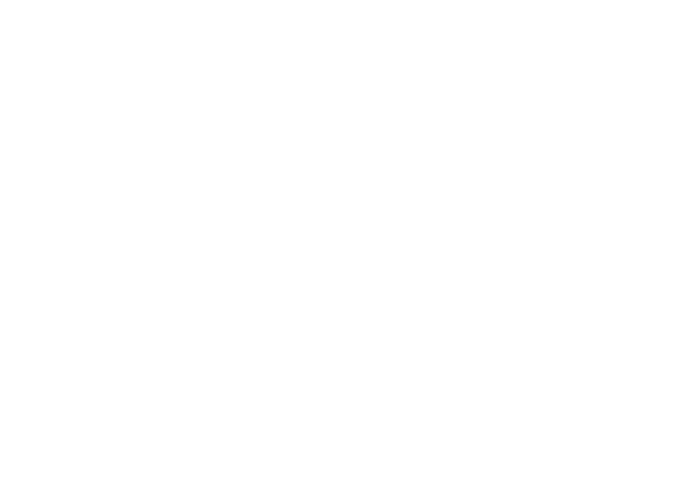

<IPython.core.display.Javascript object>


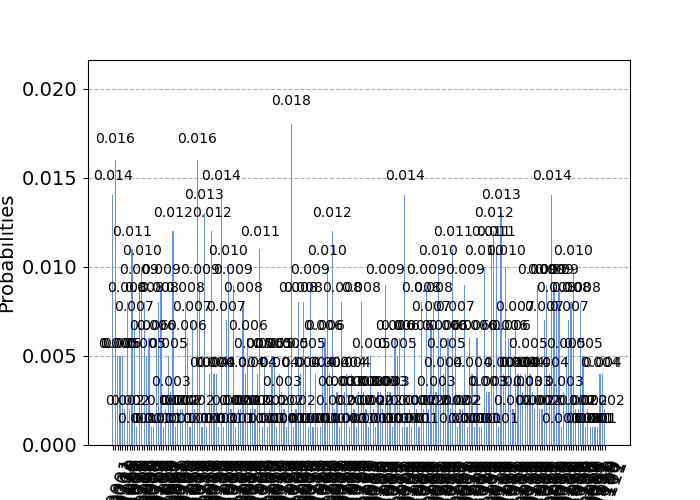

In [158]:
# qc.save_statevector()

backend = Aer.get_backend('qasm_simulator')
job = execute(qc, backend, shots=1000)
result = job.result()

counts = result.get_counts()
# statevector = result.get_statevector()
sort_counts = sorted(counts.items(), key=lambda x: x[1], reverse=True)

print(sort_counts)
plot_histogram(counts)

In [104]:
# plot_bloch_multivector(statevector)


In [143]:
x = QuantumRegister(n, 'x')
b = QuantumRegister(n, 'b')
c = QuantumRegister(1, 'c')
aux = QuantumRegister(2, 'aux')

cl = ClassicalRegister(2*n, 'cl')

qc = QuantumCircuit(c, x, b, aux)
qc.add_register(cl)

init_x = format(x_val, '05b')
print(init_x)
for i in range(n):
    if (init_x[n-1-i] == '1'):
        qc.x(x[i])

qc.x(c)
qc.x(x[0])


qubit_mult = [c[0]]
for i in range(n):
    qubit_mult.append(x[i])
for i in range(n):
    qubit_mult.append(b[i])
qubit_mult.append(aux[0])
qubit_mult.append(aux[1])

qc.append(CMULT(n, a, N), qubit_mult)

for i in range(n):
    qc.append(CSwapGate(), [c[0], x[i], b[i]])

a_inv = pow(a, -1, N)
qc.append(CMULT(n, a_inv, N).inverse(), qubit_mult)

qc.measure(x, cl[0:n])
qc.measure(b, cl[n:2*n])

qc.decompose().draw()

00001


┌───────────┐┌───────────┐┌───────────┐┌───────────┐┌───────────┐»
    c: ┤ U3(π,0,π) ├┤0          ├┤0          ├┤0          ├┤0          ├»
       ├───────────┤│           ││           ││           ││           │»
  x_0: ┤ U3(π,0,π) ├┤1          ├┤           ├┤           ├┤           ├»
       └───────────┘│           ││           ││           ││           │»
  x_1: ─────────────┤           ├┤1          ├┤           ├┤           ├»
                    │           ││           ││           ││           │»
  x_2: ─────────────┤           ├┤           ├┤1          ├┤           ├»
                    │           ││           ││           ││           │»
  x_3: ─────────────┤           ├┤           ├┤           ├┤1          ├»
          ┌──────┐  │           ││           ││           ││           │»
  b_0: ───┤0     ├──┤2 CMOD_ADD ├┤2 CMOD_ADD ├┤2 CMOD_ADD ├┤2 CMOD_ADD ├»
          │      │  │           ││           ││           ││           │»
  b_1: ───┤1     ├──┤3          ├┤3          ├┤3          ├┤3          ├»
          │      │  │           ││           ││           ││           │»
  b_2: ───┤2 QFT ├──┤4          ├┤4          ├┤4          ├┤4          ├»
          │      │  │           ││           ││           ││           │»
  b_3: ───┤3     ├──┤5          ├┤5          ├┤5          ├┤5          ├»
          │      │  │           ││           ││           ││           │»
aux_0: ───┤4     ├──┤6          ├┤6          ├┤6          ├┤6          ├»
          └──────┘  │           ││           ││           ││           │»
aux_1: ─────────────┤7          ├┤7          ├┤7          ├┤7          ├»
                    └───────────┘└───────────┘└───────────┘└───────────┘»
 cl: 8/═════════════════════════════════════════════════════════════════»
                                                                        »
«                                                                            »
«    c: ───────────────────────────────■─────────■─────────■─────────■───────»
«                ┌───┐                 │  ┌───┐  │         │         │       »
«  x_0: ─────────┤ X ├─────────────────■──┤ X ├──┼─────────┼─────────┼───────»
«                └─┬─┘┌───┐            │  └─┬─┘  │  ┌───┐  │         │       »
«  x_1: ───────────┼──┤ X ├────────────┼────┼────■──┤ X ├──┼─────────┼───────»
«                  │  └─┬─┘┌───┐       │    │    │  └─┬─┘  │  ┌───┐  │       »
«  x_2: ───────────┼────┼──┤ X ├───────┼────┼────┼────┼────■──┤ X ├──┼───────»
«                  │    │  └─┬─┘┌───┐  │    │    │    │    │  └─┬─┘  │  ┌───┐»
«  x_3: ───────────┼────┼────┼──┤ X ├──┼────┼────┼────┼────┼────┼────■──┤ X ├»
«       ┌───────┐  │    │    │  └─┬─┘┌─┴─┐  │    │    │    │    │    │  └─┬─┘»
«  b_0: ┤0      ├──■────┼────┼────┼──┤ X ├──■────┼────┼────┼────┼────┼────┼──»
«       │       │       │    │    │  └───┘     ┌─┴─┐  │    │    │    │    │  »
«  b_1: ┤1      ├───────■────┼────┼────────────┤ X ├──■────┼────┼────┼────┼──»
«       │       │            │    │            └───┘     ┌─┴─┐  │    │    │  »
«  b_2: ┤2 IQFT ├────────────■────┼──────────────────────┤ X ├──■────┼────┼──»
«       │       │                 │                      └───┘     ┌─┴─┐  │  »
«  b_3: ┤3      ├─────────────────■────────────────────────────────┤ X ├──■──»
«       │       │                                                  └───┘     »
«aux_0: ┤4      ├────────────────────────────────────────────────────────────»
«       └───────┘                                                            »
«aux_1: ─────────────────────────────────────────────────────────────────────»
«                                                                            »
« cl: 8/═════════════════════════════════════════════════════════════════════»
«                                                                            »
«                   ┌─────────────────────┐┌─────────────────────┐   »
«    c: ────────────┤0                    ├┤0                    ├───»
«                   │                   

In [133]:
c = QuantumRegister(2, 'c')
q = QuantumRegister(n, 'q')
aux = QuantumRegister(2, 'aux')
cl = ClassicalRegister(n, 'cl')
qc = QuantumCircuit(c, q, aux)

qc.x(c)

qubit_qft = []
for i in range(n):
    qubit_qft.append(q[i])
qubit_qft.append(aux[0])

qft_init = myQFT(n+1)
qc.append(qft_init, qubit_qft)

qubit_list = [c[0], c[1]]
for i in range(n):
    qubit_list.append(q[i])
qubit_list.append(aux[0])

qc.append(ADD(n+1, a).control(2), qubit_list)

qc.append(ADD(n+1, N).inverse(), qubit_qft)

iqft0 = myQFT(n+1, inverse=True)
qc.append(iqft0, qubit_qft)

qc.cx(aux[0], aux[1])

qft1 = myQFT(n+1)
qc.append(qft1, qubit_qft)

qubit_list = [aux[1]]
for i in range(n):
    qubit_list.append(q[i])
qubit_list.append(aux[0])

qc.append(ADD(n+1, N).control(1), qubit_list)

# for cleaning aux


qubit_list = [c[0], c[1]]
for i in range(n):
    qubit_list.append(q[i]) 
qubit_list.append(aux[0])

qc.append(ADD(n+1, a).inverse().control(2), qubit_list)

iqft1 = myQFT(n+1, inverse=True)
qc.append(iqft1, qubit_qft)

qc.x(aux[0])
qc.cx(aux[0], aux[1])
qc.x(aux[0])

qft2 = myQFT(n+1)
qc.append(qft2, qubit_qft)

qubit_list = [c[0], c[1]]
for i in range(n):
    qubit_list.append(q[i]) 
qubit_list.append(aux[0])

qc.append(ADD(n+1, a).control(2), qubit_list)

qft_last = myQFT(n+1, inverse=True)
qc.append(qft_last, qubit_qft)

qc.add_register(cl)



qc.measure(q, cl)
qc.draw()

┌───┐                                                               »
  c_0: ─┤ X ├─────■─────────────────────────────────────────────────────────»
        ├───┤     │                                                         »
  c_1: ─┤ X ├─────■─────────────────────────────────────────────────────────»
       ┌┴───┴─┐┌──┴───┐┌─────────────────────┐┌───────┐     ┌──────┐┌──────┐»
  q_0: ┤0     ├┤0     ├┤0                    ├┤0      ├─────┤0     ├┤0     ├»
       │      ││      ││                     ││       │     │      ││      │»
  q_1: ┤1     ├┤1     ├┤1                    ├┤1      ├─────┤1     ├┤1     ├»
       │      ││      ││                     ││       │     │      ││      │»
  q_2: ┤2 QFT ├┤2 ADD ├┤2 circuit-4575879_dg ├┤2 IQFT ├─────┤2 QFT ├┤2 ADD ├»
       │      ││      ││                     ││       │     │      ││      │»
  q_3: ┤3     ├┤3     ├┤3                    ├┤3      ├─────┤3     ├┤3     ├»
       │      ││      ││                     ││       │     │      ││      │»
aux_0: ┤4     ├┤4     ├┤4                    ├┤4      ├──■──┤4     ├┤4     ├»
       └──────┘└──────┘└─────────────────────┘└───────┘┌─┴─┐└──────┘└──┬───┘»
aux_1: ────────────────────────────────────────────────┤ X ├───────────■────»
                                                       └───┘                »
 cl: 4/═════════════════════════════════════════════════════════════════════»
                                                                            »
«                                                                      »
«  c_0: ───────────■──────────────────────────────────────────────■────»
«                  │                                              │    »
«  c_1: ───────────■──────────────────────────────────────────────■────»
«       ┌──────────┴──────────┐┌───────┐               ┌──────┐┌──┴───┐»
«  q_0: ┤0                    ├┤0      ├───────────────┤0     ├┤0     ├»
«       │                     ││       │               │      ││      │»
«  q_1: ┤1                    ├┤1      ├───────────────┤1     ├┤1     ├»
«       │                     ││       │               │      ││      │»
«  q_2: ┤2 circuit-4575904_dg ├┤2 IQFT ├───────────────┤2 QFT ├┤2 ADD ├»
«       │                     ││       │               │      ││      │»
«  q_3: ┤3                    ├┤3      ├───────────────┤3     ├┤3     ├»
«       │                     ││       │┌───┐     ┌───┐│      ││      │»
«aux_0: ┤4                    ├┤4      ├┤ X ├──■──┤ X ├┤4     ├┤4     ├»
«       └─────────────────────┘└───────┘└───┘┌─┴─┐└───┘└──────┘└──────┘»
«aux_1: ─────────────────────────────────────┤ X ├─────────────────────»
«                                            └───┘                     »
« cl: 4/═══════════════════════════════════════════════════════════════»
«                                                                      »
«                            
«  c_0: ─────────────────────
«                            
«  c_1: ─────────────────────
«       ┌───────┐┌─┐         
«  q_0: ┤0      ├┤M├─────────
«       │       │└╥┘┌─┐      
«  q_1: ┤1      ├─╫─┤M├──────
«       │       │ ║ └╥┘┌─┐   
«  q_2: ┤2 IQFT ├─╫──╫─┤M├───
«       │       │ ║  ║ └╥┘┌─┐
«  q_3: ┤3      ├─╫──╫──╫─┤M├
«       │       │ ║  ║  ║ └╥┘
«aux_0: ┤4      ├─╫──╫──╫──╫─
«       └───────┘ ║  ║  ║  ║ 
«aux_1: ──────────╫──╫──╫──╫─
«                 ║  ║  ║  ║ 
« cl: 4/══════════╩══╩══╩══╩═
«                 0  1  2  3